<a href="https://colab.research.google.com/github/shaheermasood/fake-news-detection/blob/main/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Loading the data (fake and real news dataset from Kaggle)

In [ ]:
from google.colab import files

uploaded = files.upload()

# Read the CSV files
fake_data = pd.read_csv('Fake.csv')
true_data = pd.read_csv('True.csv')


Saving Fake.csv to Fake.csv
Saving True.csv to True.csv


Merging and Labeling Data

In [ ]:
# Label the data with appropriate tags
fake_data['label'] = 0  # For fake news
true_data['label'] = 1  # For true news

# Concatenate both data frames
data = pd.concat([fake_data, true_data], ignore_index=True)

EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
None
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk

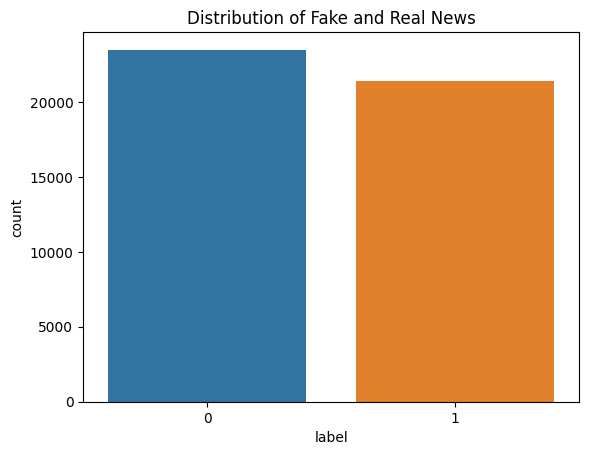

In [ ]:
# Overview of the data
print(data.info())
print(data.head())

# Visualize the distribution of fake and real news
sns.countplot(x='label', data=data)
plt.title('Distribution of Fake and Real News')
plt.show()


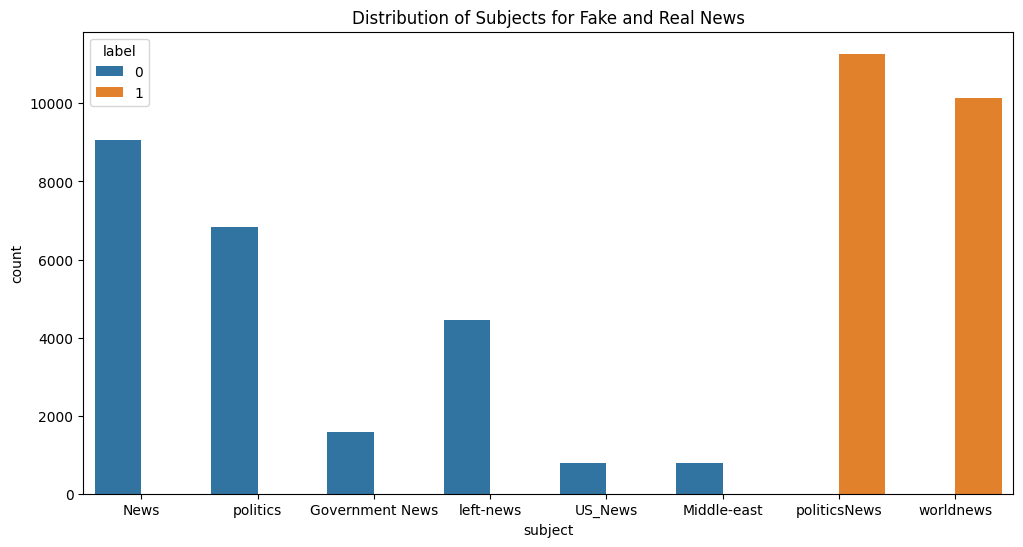

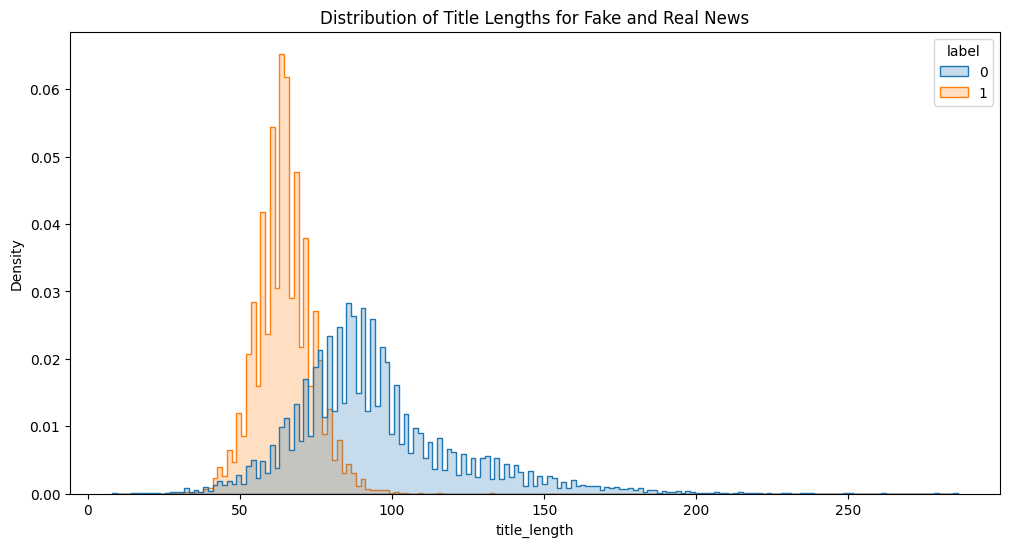

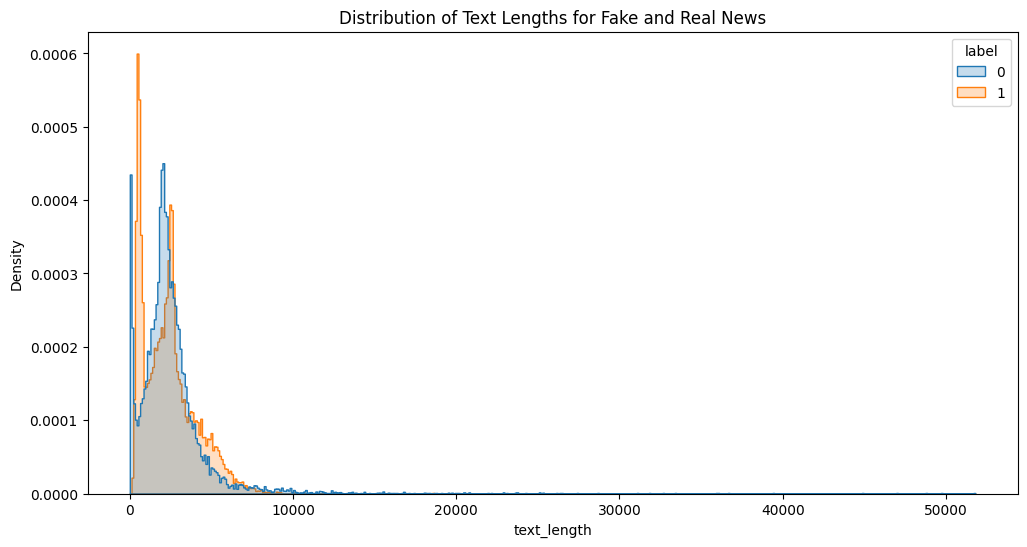

In [ ]:
# Analyzing the distribution of subjects
plt.figure(figsize=(12,6))
sns.countplot(x='subject', hue='label', data=data)
plt.title('Distribution of Subjects for Fake and Real News')
plt.show()

# Examining the lengths of titles and texts
data['title_length'] = data['title'].apply(len)
data['text_length'] = data['text'].apply(len)

plt.figure(figsize=(12,6))
sns.histplot(data, x='title_length', hue='label', element='step', stat='density', common_norm=False)
plt.title('Distribution of Title Lengths for Fake and Real News')
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(data, x='text_length', hue='label', element='step', stat='density', common_norm=False)
plt.title('Distribution of Text Lengths for Fake and Real News')
plt.show()


In [ ]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Downloading the NLTK stop words
import nltk
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Tokenize
    words = word_tokenize(text)
    # Remove stop words
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

data['text'] = data['text'].apply(preprocess_text)
data['title'] = data['title'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from sklearn.model_selection import train_test_split

# Define X and y
X = data[['title', 'text', 'subject']]
y = data['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
data['date'] = pd.to_datetime(data['date'], errors='coerce')


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Create a copy of X to avoid SettingWithCopyWarning
X = X.copy()

# Combine title and text
X['combined_text'] = X['title'] + " " + X['text']

# Vectorize the text
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(X['combined_text'])
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# One-hot encode the subject
subject_dummies = pd.get_dummies(X['subject'])

# Concatenate the TF-IDF features and subject dummies
X_tfidf_combined = pd.concat([X_tfidf_df, subject_dummies.reset_index(drop=True)], axis=1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_combined, y, test_size=0.2, random_state=42)

# Initialize the model
svm_model = SVC()

# Train the model
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4733
           1       1.00      1.00      1.00      4247

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

# Using the same SVM model
cross_val_accuracy = cross_val_score(svm_model, X_tfidf_combined, y, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", cross_val_accuracy)
print("Mean Cross-Validation Accuracy:", cross_val_accuracy.mean())
